In [1]:
import json 
import pandas as pd 
import numpy as np 
import time 
from datetime import timezone 
import os
from mplfinance.original_flavor import candlestick_ohlc
import pyupbit 
import ccxt
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torch 
import torch.nn as nn
import torch.nn.functional as F 
from transformers import *
import os 
import time 
import datetime 
import matplotlib.pyplot as plt
from tqdm import tqdm 
import numpy as np
import json
from sklearn.model_selection import train_test_split
import seaborn as sns

PyTorch version 1.7.1 available.
TensorFlow version 2.5.0 available.
/usr/local/lib/python3.6/dist-packages/torchaudio/backend/utils.py:54: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  '"sox" backend is being deprecated. '


In [2]:
btc_2019 = pd.read_csv("data_5m/2019_BTCUSDT.csv") 
btc_2020 = pd.read_csv("data_5m/2020_BTCUSDT.csv") 
btc_2021 = pd.read_csv("data_5m/2021_BTCUSDT.csv") 
btc_2022 = pd.read_csv("data_5m/2022_BTCUSDT.csv") 

eth_2019 = pd.read_csv("data_5m/2019_ETHUSDT.csv") 
eth_2020 = pd.read_csv("data_5m/2020_ETHUSDT.csv") 
eth_2021 = pd.read_csv("data_5m/2021_ETHUSDT.csv") 
eth_2022 = pd.read_csv("data_5m/2022_ETHUSDT.csv") 

xrp_2019 = pd.read_csv("data_5m/2019_XRPUSDT.csv") 
xrp_2020 = pd.read_csv("data_5m/2020_XRPUSDT.csv") 
xrp_2021 = pd.read_csv("data_5m/2021_XRPUSDT.csv") 
xrp_2022 = pd.read_csv("data_5m/2022_XRPUSDT.csv")
 
btc_2019.shape, btc_2020.shape, btc_2021.shape, btc_2022.shape, eth_2019.shape, eth_2020.shape, eth_2021.shape, eth_2022.shape, xrp_2019.shape, xrp_2020.shape, xrp_2021.shape, xrp_2022.shape

((105291, 7),
 (105685, 7),
 (105448, 7),
 (13060, 7),
 (105291, 7),
 (105685, 7),
 (105448, 7),
 (13060, 7),
 (105291, 7),
 (105685, 7),
 (105448, 7),
 (13059, 7))

In [3]:
btc_train = pd.concat([btc_2019, btc_2020, btc_2021]) 
eth_train = pd.concat([eth_2019, eth_2020, eth_2021]) 
xrp_train = pd.concat([xrp_2019, xrp_2020, xrp_2021]) 

btc_val = btc_2022 
eth_val = eth_2022
xrp_val = xrp_2022

btc_train.shape, eth_train.shape, xrp_train.shape, btc_val.shape, eth_val.shape, xrp_val.shape

((316424, 7), (316424, 7), (316424, 7), (13060, 7), (13060, 7), (13059, 7))

In [4]:
def process(df): 
    binance = ccxt.binance() 
    dates = df['Open Time'].values 
    timestamp = [] 
    for i in range(len(dates)): 
        date_string = binance.iso8601(int(dates[i])) 
        date_string = date_string[:10] + " " + date_string[11:-5] 
        timestamp.append(date_string) 
    df['datetime'] = timestamp 
    df = df.drop(columns={'0'})
    return df

In [5]:
btc_train = process(btc_train) 
eth_train = process(eth_train) 
xrp_train = process(xrp_train) 

btc_val = process(btc_val) 
eth_val = process(eth_val)
xrp_val = process(xrp_val) 

In [6]:
btc_train = btc_train.rename(columns={'Open':"BTC Open",
                                      'High':"BTC High", 
                                      'Low':"BTC Low",
                                      'Close':"BTC Close",
                                      'Volume':"BTC Volume"})

eth_train = eth_train.rename(columns={'Open':"ETH Open",
                                      'High':"ETH High", 
                                      'Low':"ETH Low",
                                      'Close':"ETH Close",
                                      'Volume':"ETH Volume"})

xrp_train = xrp_train.rename(columns={'Open':"XRP Open", 
                                      "High":"XRP High", 
                                      "Low":"XRP Low", 
                                      "Close":"XRP Close", 
                                      "Volume":"XRP Volume"}) 


btc_train = btc_train.drop(columns={'Open Time'}) 
eth_train = eth_train.drop(columns={'Open Time'})
xrp_train = xrp_train.drop(columns={'Open Time'}) 

full_df = btc_train.join(eth_train.set_index('datetime'), on='datetime')
full_df = full_df.join(xrp_train.set_index('datetime'), on='datetime')

full_df = full_df.dropna() 
full_df.head()

,BTC Open,BTC High,BTC Low,BTC Close,BTC Volume,datetime,ETH Open,ETH High,ETH Low,ETH Close,ETH Volume,XRP Open,XRP High,XRP Low,XRP Close,XRP Volume
0,3701.23,3703.72,3695.00,3696.32,85.572181,2019-01-01 00:00:00,131.45,131.54,131.01,131.27,1269.12705,0.34864,0.34866,0.34758,0.34758,88675.3
1,3696.30,3697.24,3689.88,3692.34,62.296581,2019-01-01 00:05:00,131.26,131.35,131.12,131.29,1601.91843,0.34753,0.34765,0.34703,0.34723,59894.3
2,3692.34,3698.93,3692.34,3697.31,43.105333,2019-01-01 00:10:00,131.27,131.36,131.19,131.31,560.54337,0.34733,0.34791,0.34727,0.34764,128935.0
3,3697.91,3698.75,3693.00,3693.00,48.551084,2019-01-01 00:15:00,131.30,131.36,131.25,131.30,651.89505,0.34772,0.34794,0.34732,0.34760,63715.1
4,3693.44,3695.98,3690.92,3692.18,47.706443,2019-01-01 00:20:00,131.26,131.44,131.25,131.28,500.58218,0.34748,0.34786,0.34723,0.34731,88674.5


In [16]:
full_df = full_df[full_df['BTC Volume'] != 0] 

full_df.shape

(325819, 16)

In [17]:
minutes = [] 
hours = []
days = [] 
months = [] 
for dt in tqdm(full_df['datetime']):
    minute = pd.to_datetime(dt).minute
    hour = pd.to_datetime(dt).hour 
    day = pd.to_datetime(dt).day 
    month = pd.to_datetime(dt).month 
    minutes.append(minute)
    hours.append(hour) 
    days.append(day) 
    months.append(month)
    
full_df['Minutes'] = minutes
full_df['Hours'] = hours
full_df['Days'] = days 
full_df['Months'] = months 

100%|██████████| 325819/325819 [02:50<00:00, 1911.31it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

In [18]:
print("Train Duration: from {} to {}".format(full_df['datetime'].values[0], full_df['datetime'].values[-1]))

Train Duration: from 2019-01-01 00:00:00 to 2021-12-31 23:55:00


In [19]:
full_df = full_df.drop(columns={'datetime'}) 
full_df.head()

,BTC Open,BTC High,BTC Low,BTC Close,BTC Volume,ETH Open,ETH High,ETH Low,ETH Close,ETH Volume,XRP Open,XRP High,XRP Low,XRP Close,XRP Volume,Minutes,Hours,Days,Months
0,3701.23,3703.72,3695.00,3696.32,85.572181,131.45,131.54,131.01,131.27,1269.12705,0.34864,0.34866,0.34758,0.34758,88675.3,0,0,1,1
1,3696.30,3697.24,3689.88,3692.34,62.296581,131.26,131.35,131.12,131.29,1601.91843,0.34753,0.34765,0.34703,0.34723,59894.3,5,0,1,1
2,3692.34,3698.93,3692.34,3697.31,43.105333,131.27,131.36,131.19,131.31,560.54337,0.34733,0.34791,0.34727,0.34764,128935.0,10,0,1,1
3,3697.91,3698.75,3693.00,3693.00,48.551084,131.30,131.36,131.25,131.30,651.89505,0.34772,0.34794,0.34732,0.34760,63715.1,15,0,1,1
4,3693.44,3695.98,3690.92,3692.18,47.706443,131.26,131.44,131.25,131.28,500.58218,0.34748,0.34786,0.34723,0.34731,88674.5,20,0,1,1


# Feature Engineering for train data + create train dataloader

In [21]:
def differencing(df, lookback=121, epsilon=1e-10): 
    columns = ["BTC Open", "BTC High", "BTC Low", "BTC Close", "BTC Volume", 
               "ETH Open", "ETH High", "ETH Low", "ETH Close", "ETH Volume",
               "XRP Open", "XRP High", "XRP Low", "XRP Close", "XRP Volume"]
    for col in columns: 
        feature_values = df[col].values  
        d = {} 
        for i in range(1, lookback): 
            d['{}_Differenced_{}'.format(col, i)] = []
        for i in tqdm(range(df.shape[0]), position=0, leave=True): 
            if i < lookback: 
                for j in range(1, lookback): 
                    d['{}_Differenced_{}'.format(col, j)].append(None)
            else: 
                for j in range(1, lookback): 
                    if col == "BTC Volume" or col == "ETH Volume" or col == "XRP Volume": 
                        # simple differencing for volume to prevent zero division
                        ret = feature_values[i] / (feature_values[i-j] + epsilon)
                    else: 
                        ret = feature_values[i] / feature_values[i-j] 
                    d['{}_Differenced_{}'.format(col, j)].append(ret) 
        for key, value in d.items():
            df[key] = value
    return df 


def feature_engineering(df): 
    print("===== Feature Engineering =====")
    windows = [5, 10, 20, 60, 120]
    
    for window in windows: 
        df['BTC_Open_ma{}'.format(window)] = df['BTC Open'].rolling(window).mean() 
        df['BTC_Open_ma{}_ratio'.format(window)] = (df['BTC Open'] - df['BTC_Open_ma{}'.format(window)]) / df['BTC_Open_ma{}'.format(window)]

        df['BTC_High_ma{}'.format(window)] = df['BTC High'].rolling(window).mean()
        df['BTC_High_ma{}_ratio'.format(window)] = (df['BTC High'] - df['BTC_High_ma{}'.format(window)]) / df['BTC_High_ma{}'.format(window)]

        df['BTC_Low_ma{}'.format(window)] = df['BTC Low'].rolling(window).mean() 
        df['BTC_Low_ma{}_ratio'.format(window)] = (df['BTC Low'] - df['BTC_Low_ma{}'.format(window)]) / df['BTC_Low_ma{}'.format(window)]
        
        df['BTC_Close_ma{}'.format(window)] = df['BTC Close'].rolling(window).mean() 
        df['BTC_Close_ma{}_ratio'.format(window)] = (df['BTC Close'] - df['BTC_Close_ma{}'.format(window)]) / df['BTC_Close_ma{}'.format(window)]

        df['BTC_Volume_ma{}'.format(window)] = df['BTC Volume'].rolling(window).mean() 
        df['BTC_Volume_ma{}_ratio'.format(window)] = (df['BTC Volume'] - df['BTC_Volume_ma{}'.format(window)]) / df['BTC_Volume_ma{}'.format(window)]
        
        df['ETH_Open_ma{}'.format(window)] = df['ETH Open'].rolling(window).mean() 
        df['ETH_Open_ma{}_ratio'.format(window)] = (df['ETH Open'] - df['ETH_Open_ma{}'.format(window)]) / df['ETH_Open_ma{}'.format(window)] 
        
        df['ETH_High_ma{}'.format(window)] = df['ETH High'].rolling(window).mean() 
        df['ETH_High_ma{}_ratio'.format(window)] = (df['ETH High'] - df['ETH_High_ma{}'.format(window)]) / df['ETH_High_ma{}'.format(window)] 
        
        df['ETH_Low_ma{}'.format(window)] = df['ETH Low'].rolling(window).mean() 
        df['ETH_Low_ma{}_ratio'.format(window)] = (df['ETH Low'] - df['ETH_Low_ma{}'.format(window)]) / df['ETH_Low_ma{}'.format(window)] 
        
        df['ETH_Close_ma{}'.format(window)] = df['ETH Close'].rolling(window).mean() 
        df['ETH_Close_ma{}_ratio'.format(window)] = (df['ETH Close'] - df['ETH_Close_ma{}'.format(window)]) / df['ETH_Close_ma{}'.format(window)]

        df['ETH_Volume_ma{}'.format(window)] = df['ETH Volume'].rolling(window).mean() 
        df['ETH_Volume_ma{}_ratio'.format(window)] = (df['ETH Volume'] - df['ETH_Volume_ma{}'.format(window)]) / df['ETH_Volume_ma{}'.format(window)]
        
        df['XRP_Open_ma{}'.format(window)] = df['XRP Open'].rolling(window).mean() 
        df['XRP_Open_ma{}_ratio'.format(window)] = (df['XRP Open'] - df['XRP_Open_ma{}'.format(window)]) / df['XRP_Open_ma{}'.format(window)]

        df['XRP_High_ma{}'.format(window)] = df['XRP High'].rolling(window).mean()
        df['XRP_High_ma{}_ratio'.format(window)] = (df['XRP High'] - df['XRP_High_ma{}'.format(window)]) / df['XRP_High_ma{}'.format(window)]

        df['XRP_Low_ma{}'.format(window)] = df['XRP Low'].rolling(window).mean() 
        df['XRP_Low_ma{}_ratio'.format(window)] = (df['XRP Low'] - df['XRP_Low_ma{}'.format(window)]) / df['XRP_Low_ma{}'.format(window)]
        
        df['XRP_Close_ma{}'.format(window)] = df['XRP Close'].rolling(window).mean() 
        df['XRP_Close_ma{}_ratio'.format(window)] = (df['XRP Close'] - df['XRP_Close_ma{}'.format(window)]) / df['XRP_Close_ma{}'.format(window)]

        df['XRP_Volume_ma{}'.format(window)] = df['XRP Volume'].rolling(window).mean() 
        df['XRP_Volume_ma{}_ratio'.format(window)] = (df['XRP Volume'] - df['XRP_Volume_ma{}'.format(window)]) / df['XRP_Volume_ma{}'.format(window)]
    
    # df = differencing(df)  
    df = df.dropna() 
    
    print("===== Create Target Array =====")
    K = 6 # forecasting window 
    targets = []
    open_values = df['BTC Open'].values 
    for i in tqdm(range(open_values.shape[0] - K)):
        target = [] 
        for j in range(1,K+1): 
            ret = open_values[i+j] / open_values[i] 
            target.append(ret) 
        targets.append(target) 

    print("===== Create Future Discrete Array =====")
    future_discs = []
    disc_values = df[["Minutes","Hours","Days","Months"]] 
    
    for i in tqdm(range(disc_values.shape[0] - K)):
        future_disc = [] 
        for j in range(1,K+1):
            future_disc.append(disc_values.iloc[i+j,:])
        future_discs.append(future_disc)
    
    print("===== Get rid of unnecessary columns for training or validation =====")
    df = df.iloc[:-K] 
    remove_cols = ["BTC Open",
                   "BTC High",
                   "BTC Low", 
                   "BTC Close", 
                   "BTC Volume", 
                   "ETH Open", 
                   "ETH High", 
                   "ETH Low", 
                   "ETH Close", 
                   "ETH Volume", 
                   "XRP Open", 
                   "XRP High", 
                   "XRP Low", 
                   "XRP Close", 
                   "XRP Volume"]
    for ticker in ["BTC","ETH","XRP"]: 
        for chart_info in ["Open", "High", "Low", "Close", "Volume"]: 
            for w in [5,10,20,60,120]:
                remove_cols.append("{}_{}_ma{}".format(ticker, chart_info, w)) 
    
    relevant_cols = [] 
    cols = df.columns 
    for col in cols: 
        if col not in remove_cols: 
            relevant_cols.append(col) 
    
    df = df[relevant_cols] 
    print("Done!")
    return df, targets, future_discs  


In [22]:
train_df, train_targets, train_future_discs = feature_engineering(full_df)

===== Feature Engineering =====
===== Create Target Array =====


100%|██████████| 325694/325694 [00:01<00:00, 169283.23it/s]


===== Create Future Discrete Array =====


100%|██████████| 325694/325694 [05:25<00:00, 1002.03it/s]

===== Get rid of unnecessary columns for training or validation =====
Done!


In [23]:
train_df.shape[0], len(train_targets), len(train_future_discs)

(325694, 325694, 325694)

In [63]:
train_df.head()

,Minutes,Hours,Days,Months,BTC_Open_ma5_ratio,BTC_High_ma5_ratio,BTC_Low_ma5_ratio,BTC_Close_ma5_ratio,BTC_Volume_ma5_ratio,ETH_Open_ma5_ratio,...,ETH_Open_ma120_ratio,ETH_High_ma120_ratio,ETH_Low_ma120_ratio,ETH_Close_ma120_ratio,ETH_Volume_ma120_ratio,XRP_Open_ma120_ratio,XRP_High_ma120_ratio,XRP_Low_ma120_ratio,XRP_Close_ma120_ratio,XRP_Volume_ma120_ratio
119,55,9,1,1,-0.000643,-0.002417,-0.000573,-0.000509,-0.186598,-0.000941,...,0.009547,0.008113,0.009846,0.008727,-0.347390,0.003082,0.002255,0.003353,0.002672,-0.544333
120,0,10,1,1,-0.000577,-0.001724,0.000030,-0.000223,-0.474245,-0.000688,...,0.008875,0.008569,0.009677,0.009321,-0.367755,0.002960,0.002554,0.003866,0.003661,-0.472519
121,5,10,1,1,-0.000168,-0.001280,0.000440,0.000519,-0.283991,0.000209,...,0.009317,0.009231,0.010265,0.009985,-0.467408,0.003408,0.003081,0.004303,0.003868,-0.658736
122,10,10,1,1,0.000708,0.001398,0.001070,0.001996,-0.254096,0.000822,...,0.010129,0.010260,0.011225,0.010792,-0.330453,0.003959,0.003354,0.002985,0.003828,-0.460883
123,15,10,1,1,0.001815,0.001735,0.001795,0.001846,-0.149319,0.001434,...,0.010860,0.009785,0.010232,0.009721,-0.488285,0.004428,0.003257,0.004824,0.004493,-0.559083


In [24]:
K = 6 # forecasting window 

disc_cols = ["Minutes", "Hours", "Days", "Months"] 
cont_cols = [] 
cols = train_df.columns 
for col in cols: 
    if col not in disc_cols: 
        cont_cols.append(col) 
        
train_cont = train_df[cont_cols].values 
train_disc = train_df[disc_cols].values

train_cont = torch.tensor(train_cont, dtype=torch.float32) 
train_disc = torch.tensor(train_disc, dtype=torch.float32) 

num_cont_features = len(cont_cols)
num_disc_features = len(disc_cols)

train_cont = torch.reshape(train_cont, (-1, 1, num_cont_features, 1)) 
train_disc = torch.reshape(train_disc, (-1, 1, num_disc_features)) 

train_targets = torch.tensor(train_targets, dtype=torch.float32) 
train_targets = torch.reshape(train_targets, (-1, K, 1))  

train_future_discs = torch.tensor(train_future_discs, dtype=torch.float32) 
train_future_discs = torch.reshape(train_future_discs, (-1, K, num_disc_features)) 


train_cont.shape, train_targets.shape, train_disc.shape, train_future_discs.shape 

(torch.Size([325694, 1, 75, 1]),
 torch.Size([325694, 6, 1]),
 torch.Size([325694, 1, 4]),
 torch.Size([325694, 6, 4]))

In [25]:
BATCH_SIZE = 128

class CustomDataset(Dataset): 
    def __init__(self, past_cont, past_disc, target_seq, future_disc): 
        self.past_cont = past_cont
        self.past_disc = past_disc 
        self.target_seq = target_seq  
        self.future_disc = future_disc 
        
    def __len__(self): 
        return len(self.past_cont) 
    
    def __getitem__(self, i):  
        return {
            'past_cont': torch.tensor(self.past_cont[i], dtype=torch.float32), 
            'past_disc': torch.tensor(self.past_disc[i], dtype=torch.float32), 
            'target_seq': torch.tensor(self.target_seq[i], dtype=torch.float32),  
            'future_disc': torch.tensor(self.future_disc[i], dtype=torch.float32),  
        }

train_dataset = CustomDataset(train_cont, train_disc, train_targets, train_future_discs)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True) 

# Feature Engineering for val data + Create Val DataLoader

In [26]:
btc_val = btc_val.rename(columns={'Open':"BTC Open",
                                  'High':"BTC High", 
                                  'Low':"BTC Low",
                                  'Close':"BTC Close",
                                  'Volume':"BTC Volume"})

eth_val = eth_val.rename(columns={'Open':"ETH Open",
                                  'High':"ETH High", 
                                  'Low':"ETH Low",
                                  'Close':"ETH Close",
                                  'Volume':"ETH Volume"}) 

xrp_val = xrp_val.rename(columns={'Open':"XRP Open", 
                                  'High':"XRP High",
                                  'Low':"XRP Low",
                                  'Close':"XRP Close", 
                                  "Volume":"XRP Volume"}) 


btc_val = btc_val.drop(columns={'Open Time'}) 
eth_val = eth_val.drop(columns={'Open Time'}) 
xrp_val = xrp_val.drop(columns={'Open Time'})
full_val = btc_val.merge(eth_val, on='datetime').merge(xrp_val, on='datetime') 

full_val = full_val.dropna() 
full_val.head()

,BTC Open,BTC High,BTC Low,BTC Close,BTC Volume,datetime,ETH Open,ETH High,ETH Low,ETH Close,ETH Volume,XRP Open,XRP High,XRP Low,XRP Close,XRP Volume
0,46216.93,46391.49,46208.37,46321.34,185.67558,2022-01-01 00:00:00,3676.22,3695.41,3676.22,3690.09,1363.4570,0.8298,0.8351,0.8297,0.8334,945000.0
1,46321.34,46527.26,46280.00,46371.11,123.43577,2022-01-01 00:05:00,3690.12,3705.90,3686.70,3696.55,862.5494,0.8333,0.8364,0.8328,0.8330,468801.0
2,46369.79,46394.00,46276.22,46332.51,77.54574,2022-01-01 00:10:00,3696.55,3699.81,3686.70,3691.90,753.5524,0.8330,0.8341,0.8308,0.8322,631674.0
3,46332.52,46332.52,46236.27,46293.90,101.14315,2022-01-01 00:15:00,3691.90,3693.35,3685.83,3689.51,438.4134,0.8322,0.8329,0.8311,0.8319,346621.0
4,46295.42,46421.27,46286.25,46395.53,135.32479,2022-01-01 00:20:00,3689.51,3699.58,3688.60,3699.45,372.5966,0.8320,0.8352,0.8318,0.8349,546138.0


In [27]:
val_minutes = [] 
val_hours = []
val_days = [] 
val_months = [] 
for dt in tqdm(full_val['datetime']):
    minute = pd.to_datetime(dt).minute
    hour = pd.to_datetime(dt).hour 
    day = pd.to_datetime(dt).day 
    month = pd.to_datetime(dt).month 
    val_minutes.append(minute)
    val_hours.append(hour) 
    val_days.append(day) 
    val_months.append(month)
    
full_val['Minutes'] = val_minutes
full_val['Hours'] = val_hours
full_val['Days'] = val_days 
full_val['Months'] = val_months 

100%|██████████| 13443/13443 [00:06<00:00, 2035.93it/s]


In [28]:
print("Validation Duration: from {} to {}".format(full_val['datetime'].values[0], full_val['datetime'].values[-1]))

Validation Duration: from 2022-01-01 00:00:00 to 2022-02-15 02:50:00


In [29]:
full_val = full_val.drop(columns={'datetime'}) 
full_val.head()

,BTC Open,BTC High,BTC Low,BTC Close,BTC Volume,ETH Open,ETH High,ETH Low,ETH Close,ETH Volume,XRP Open,XRP High,XRP Low,XRP Close,XRP Volume,Minutes,Hours,Days,Months
0,46216.93,46391.49,46208.37,46321.34,185.67558,3676.22,3695.41,3676.22,3690.09,1363.4570,0.8298,0.8351,0.8297,0.8334,945000.0,0,0,1,1
1,46321.34,46527.26,46280.00,46371.11,123.43577,3690.12,3705.90,3686.70,3696.55,862.5494,0.8333,0.8364,0.8328,0.8330,468801.0,5,0,1,1
2,46369.79,46394.00,46276.22,46332.51,77.54574,3696.55,3699.81,3686.70,3691.90,753.5524,0.8330,0.8341,0.8308,0.8322,631674.0,10,0,1,1
3,46332.52,46332.52,46236.27,46293.90,101.14315,3691.90,3693.35,3685.83,3689.51,438.4134,0.8322,0.8329,0.8311,0.8319,346621.0,15,0,1,1
4,46295.42,46421.27,46286.25,46395.53,135.32479,3689.51,3699.58,3688.60,3699.45,372.5966,0.8320,0.8352,0.8318,0.8349,546138.0,20,0,1,1


In [30]:
val_df, val_targets, val_future_discs = feature_engineering(full_val) 

===== Feature Engineering =====
===== Create Target Array =====


100%|██████████| 13318/13318 [00:00<00:00, 245940.56it/s]


===== Create Future Discrete Array =====


100%|██████████| 13318/13318 [00:13<00:00, 989.71it/s] 

===== Get rid of unnecessary columns for training or validation =====
Done!


In [31]:
val_df.shape[0], len(val_targets), len(val_future_discs) 

(13318, 13318, 13318)

In [34]:
K = 6 # forecasting window 

disc_cols = ["Minutes", "Hours", "Days", "Months"] 
cont_cols = [] 
cols = train_df.columns 
for col in cols: 
    if col not in disc_cols: 
        cont_cols.append(col) 
        
val_cont = val_df[cont_cols].values 
val_disc = val_df[disc_cols].values

val_cont = torch.tensor(val_cont, dtype=torch.float32) 
val_disc = torch.tensor(val_disc, dtype=torch.float32) 

num_cont_features = len(cont_cols) 
num_disc_features = len(disc_cols)

val_cont = torch.reshape(val_cont, (-1, 1, num_cont_features, 1)) 
val_disc = torch.reshape(val_disc, (-1, 1, num_disc_features))  

val_targets = torch.tensor(val_targets, dtype=torch.float32) 
val_targets = torch.reshape(val_targets, (-1, K, 1))  

val_future_discs = torch.tensor(val_future_discs, dtype=torch.float32) 
val_future_discs = torch.reshape(val_future_discs, (-1, K, num_disc_features)) 


val_cont.shape, val_targets.shape, val_disc.shape, val_future_discs.shape 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


(torch.Size([13318, 1, 75, 1]),
 torch.Size([13318, 6, 1]),
 torch.Size([13318, 1, 4]),
 torch.Size([13318, 6, 4]))

In [35]:
val_dataset = CustomDataset(val_cont, val_disc, val_targets, val_future_discs)  
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle = False) 

# Define Temporal Fusion Transformer

In [36]:
def a_norm(Q, K): 
    m = torch.matmul(Q, K.transpose(2,1).float()) 
    m /= torch.sqrt(torch.tensor(Q.shape[-1]).float()) 
    return torch.softmax(m, -1) 

def attention(Q, K, V): 
    a = a_norm(Q, K) # (batch_size, dim_attn, seq_length) 
    return torch.matmul(a, V) # (batch_size, seq_length, seq_length) 

class AttentionBlock(torch.nn.Module): 
    def __init__(self, dim_val, dim_attn): 
        super(AttentionBlock, self).__init__()
        self.value = Value(dim_val, dim_val) 
        self.key = Key(dim_val, dim_attn) 
        self.query = Query(dim_val, dim_attn) 
    
    def forward(self, x, kv = None):
        if kv is None:
            # Attention with x connected to Q,K and V (For encoder)
            return attention(self.query(x), self.key(x), self.value(x))
        # Attention with x as Q, external vector kv as K and V (For decoder)
        return attention(self.query(x), self.key(kv), self.value(kv))
    
class MultiHeadAttentionBlock(torch.nn.Module):
    def __init__(self, dim_val, dim_attn, n_heads):
        super(MultiHeadAttentionBlock, self).__init__()
        self.heads = []
        for i in range(n_heads):
            self.heads.append(AttentionBlock(dim_val, dim_attn))
        
        self.fc = nn.Linear(n_heads * dim_val, dim_val, bias = False)
                      
    def forward(self, x, kv = None):
        a = []
        for h in self.heads:
            a.append(h(x, kv = kv))
            
        a = torch.stack(a, dim = -1) #combine heads
        a = a.flatten(start_dim = 2) #flatten all head outputs
        
        x = self.fc(a)
        return x
    
class Value(torch.nn.Module):
    def __init__(self, dim_input, dim_val):
        super(Value, self).__init__()
        self.fc1 = nn.Linear(dim_input, dim_val, bias = False).cuda()
    
    def forward(self, x):
        return self.fc1(x)

class Key(torch.nn.Module):
    def __init__(self, dim_input, dim_attn):
        super(Key, self).__init__()
        self.fc1 = nn.Linear(dim_input, dim_attn, bias = False).cuda()
    
    def forward(self, x):
        return self.fc1(x)

class Query(torch.nn.Module):
    def __init__(self, dim_input, dim_attn):
        super(Query, self).__init__()
        self.fc1 = nn.Linear(dim_input, dim_attn, bias = False).cuda()
    
    def forward(self, x):
        return self.fc1(x)

def QuantileLoss(net_out, Y, q):
    return (q * F.relu(net_out - Y)) + ((1 - q) * F.relu(Y - net_out))

In [37]:
class GLU(torch.nn.Module):
    def __init__(self, dim_input):
        super(GLU, self).__init__()
        self.fc1 = nn.Linear(dim_input, dim_input)
        self.fc2 = nn.Linear(dim_input, dim_input)
    
    def forward(self, x):
        return torch.sigmoid(self.fc1(x)) * self.fc2(x) 

In [38]:
class GRN(torch.nn.Module): 
    def __init__(self, dim_input, dim_out=None, n_hidden=10, dropout_r=0.1):
        super(GRN, self).__init__() 
        if dim_out != None: 
            self.skip = nn.Linear(dim_input, dim_out) 
        else:
            self.skip = None
            dim_out = dim_input 
        self.fc1 = nn.Linear(dim_input, n_hidden) 
        self.fc2 = nn.Linear(n_hidden, dim_out) 
        self.dropout = nn.Dropout(dropout_r) 
        self.gate = GLU(dim_out) 
        self.norm = nn.LayerNorm(dim_out) 
        
    def forward(self, x):
        a = F.elu(self.fc1(x))
        a = self.dropout(self.fc2(a))
        a = self.gate(a)
        if self.skip != None:
            return self.norm(self.skip(x) + a)
        return self.norm(x + a)

In [39]:
class VSN(torch.nn.Module): 
    def __init__(self, n_var_cont, n_var_disc, dim_model, dropout_r=0.1): 
        super(VSN, self).__init__()
        n_var_total = n_var_cont + len(n_var_disc)
        # linear transformation of inputs into dmodel vectors 
        self.linearise = []
        for i in range(n_var_cont): 
            self.linearise.append(nn.Linear(1, dim_model, bias=False).cuda()) 
        
        self.fc = nn.Linear(1, dim_model, bias=False).cuda()     
        # entity embeddings for discrete inputs 
        self.entity_embed = [] 
        for i in n_var_disc: 
            self.entity_embed.append(nn.Linear(i, dim_model, bias=False).cuda())  
        
        self.input_grn = GRN(dim_model, dropout_r = dropout_r) 
        self.vs_grn = GRN(n_var_total * dim_model, dim_out=n_var_total, dropout_r = dropout_r)
    
    # input (batch_size, seq_len, n_variables, input_size)
    def forward(self, x_cont, x_disc): 
        # linearise continuous inputs 
        linearised = [] 
        for idx, fc in enumerate(self.linearise): 
            linearised.append(fc(x_cont[:,:,idx])) 
        # entity embeddings for discrete inputs 
        embedded = []
        '''
        for idx, fc in enumerate(self.entity_embed): 
            embedded.append(fc(x_disc[:,:,idx]))
        '''
        for x, fc in zip(x_disc, self.entity_embed): 
            embedded.append(fc(x)) 

        if len(self.linearise) != 0 and len(self.entity_embed) != 0: 
            linearised = torch.stack(linearised, dim=-2) 
            embedded = torch.stack(embedded, dim=-2)    
            vectorised_vars = torch.cat((linearised, embedded), dim=-2) # (batch_size, seq_len, dim_model, n_vars_total)
        elif len(self.linearise) != 0 and len(self.entity_embed) == 0: 
            vectorised_vars = torch.stack(linearised, dim=-2) # (batch_size, seq_len, n_var_cont, dim_model)
        elif len(self.entity_embed) != 0 and len(self.linearise) == 0: 
            vectorised_vars = torch.stack(embedded, dim=-2)
        
        # flatten everything except accross batch for variable selection weights 
        vs_weights = self.vs_grn(vectorised_vars.flatten(start_dim=2)) # (batch_size, seq_len, n_variables)
        vs_weights = torch.softmax(vs_weights, dim=-1).unsqueeze(-1) # (batch_size, seq_len, n_variables, 1) 
        
        # input_grn applied to every input separately 
        input_weights = self.input_grn(vectorised_vars) # (batch_size, seq_len, n_variables, dim_model)
        
        x = torch.sum((vs_weights * input_weights), dim = 2) 
        return x, vs_weights # returns (batch_size, seq_len, dim_model)
        

In [40]:
class LSTMLayer(torch.nn.Module): 
    def __init__(self, dim_model, n_layers = 1, dropout_r = 0.1):
        super(LSTMLayer, self).__init__()
        self.n_layers = n_layers 
        self.dim_model = dim_model 
        self.lstm = nn.LSTM(dim_model, dim_model, num_layers = n_layers, batch_first = True) 
        self.hidden = None
        self.dropout = nn.Dropout(dropout_r) 
    
    # takes input (batch_size, seq_len, dim_model)
    def forward(self, x): 
        if self.hidden == None: 
            raise Exception("Call reset() to initialise LSTM Layer") 
            
        x, self.hidden = self.lstm(x, self.hidden) 
        x = self.dropout(x) 
        return x, self.hidden # returns (batch_size, seq_len, dim_model), hidden 
    
    def reset(self, batch_size, gpu = True): 
        if not gpu: 
            dtype = torch.FloatTensor 
        else: 
            dtype = torch.cuda.FloatTensor
        self.hidden = (torch.zeros([self.n_layers, batch_size, self.dim_model]).type(dtype),
                       torch.zeros([self.n_layers, batch_size, self.dim_model]).type(dtype)) 

In [41]:
class TFN(torch.nn.Module): 
    def __init__(self, 
                 n_var_past_cont, 
                 n_var_future_cont,
                 n_var_past_disc, 
                 n_var_future_disc,
                 dim_model,
                 n_quantiles = 1, 
                 dropout_r = 0.1,
                 n_lstm_layers = 1,
                 n_attention_layers = 1,
                 n_heads = 4):
        super(TFN, self).__init__()
        self.vs_past = VSN(n_var_past_cont, n_var_past_disc, dim_model, dropout_r = dropout_r) 
        self.vs_future = VSN(n_var_future_cont, n_var_future_disc, dim_model, dropout_r = dropout_r)
        
        self.enc = LSTMLayer(dim_model, dropout_r = dropout_r, n_layers = n_lstm_layers) 
        self.dec = LSTMLayer(dim_model, dropout_r = dropout_r, n_layers = n_lstm_layers) 
        
        self.gate1 = GLU(dim_model) 
        self.norm1 = nn.LayerNorm(dim_model) 
        
        self.static_enrich_grn = GRN(dim_model, dropout_r = dropout_r)
        
        self.attention = [] 
        for i in range(n_attention_layers): 
            self.attention.append([MultiHeadAttentionBlock(dim_model, dim_model, n_heads = n_heads).cuda(),
                                   nn.LayerNorm(dim_model).cuda()]) 
        
        self.norm2 = nn.LayerNorm(dim_model) 
        self.positionwise_grn = GRN(dim_model, dropout_r = dropout_r) 
        self.norm3 = nn.LayerNorm(dim_model) 
        self.dropout = nn.Dropout(dropout_r) 
        self.fc_out = nn.Linear(dim_model, n_quantiles) 
        
    # takes input (batch_size, past_seq_len, n_variables_past) 
    # and (batch_size, future_seq_len, n_variables_future) 
    def forward(self, x_past_cont, x_past_disc, x_future_cont, x_future_disc):
        # Encoder 
        x_past, vs_weights = self.vs_past(x_past_cont, x_past_disc) 
        e, e_hidden = self.enc(x_past) 
        self.dec_hidden = e_hidden 
        e = self.dropout(e) 
        x_past = self.norm1(self.gate1(e) + x_past) 

        # Decoder
        x_future, _ = self.vs_future(x_future_cont, x_future_disc) 
        d, _ = self.dec(x_future) 
        d = self.dropout(d) 
        x_future = self.norm1(self.gate1(d) + x_future) 

        # static enrichment
        x = torch.cat((x_past, x_future), dim=1) # (batch_size, past_seq_len + future_seq_len, dim_model)
        attention_res = x_future
        x = self.static_enrich_grn(x) 

        # attention layer 
        a = self.attention[0][1](self.attention[0][0](x) + x) 
        for at in self.attention[1:]:
            a = at[1](at[0](a) + a) 
        x_future = self.norm2(a[:, x_past.shape[1]:] + x_future) 
        a = self.positionwise_grn(x_future) 
        x_future = self.norm3(a + x_future + attention_res) 
        net_out = self.fc_out(x_future)  
        return net_out, vs_weights 

    def reset(self, batch_size, gpu = True): 
        self.enc.reset(batch_size, gpu) 
        self.dec.reset(batch_size, gpu) 

In [46]:
features = train_cont.shape[2]

model = TFN(n_var_past_cont = features,
            n_var_future_cont = 0, 
            n_var_past_disc = [60, 24, 32, 13], # minutes, hours, days, months
            n_var_future_disc = [60, 24, 32, 13],
            dim_model = 160) 

model.cuda()


TFN(
  (vs_past): VSN(
    (fc): Linear(in_features=1, out_features=160, bias=False)
    (input_grn): GRN(
      (fc1): Linear(in_features=160, out_features=10, bias=True)
      (fc2): Linear(in_features=10, out_features=160, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (gate): GLU(
        (fc1): Linear(in_features=160, out_features=160, bias=True)
        (fc2): Linear(in_features=160, out_features=160, bias=True)
      )
      (norm): LayerNorm((160,), eps=1e-05, elementwise_affine=True)
    )
    (vs_grn): GRN(
      (skip): Linear(in_features=12640, out_features=79, bias=True)
      (fc1): Linear(in_features=12640, out_features=10, bias=True)
      (fc2): Linear(in_features=10, out_features=79, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (gate): GLU(
        (fc1): Linear(in_features=79, out_features=79, bias=True)
        (fc2): Linear(in_features=79, out_features=79, bias=True)
      )
      (norm): LayerNorm((79,), eps=1e-05, elementwise_a

In [47]:
device = torch.device('cuda')

epochs = 100

optimizer = torch.optim.Adam(model.parameters(), lr=5e-5) 

train_losses, val_losses = [], []  

criterion = nn.MSELoss()  

total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

In [48]:
def evaluate(data_dataloader): 
    eval_loss = 0 
    for step, batch in enumerate(tqdm(data_dataloader, desc="Iteration", smoothing=0.05, position=0, leave=True)): 
        past_cont = batch['past_cont'].to(device) 
        past_disc = batch['past_disc'].to(device) 
        target_seq = batch['target_seq'].to(device) 
        future_disc = batch['future_disc'].to(device)
        
        past_disc = one_hot(past_disc, [60, 24, 32, 13]) 
        future_disc = one_hot(future_disc, [60, 24, 32, 13]) 
        
        model.reset(batch_size=past_cont.shape[0], gpu=True) 
        with torch.no_grad():
            net_out, vs_weights = model(past_cont, past_disc, None, future_disc)  
        loss = criterion(net_out, target_seq)
        eval_loss += loss.item() 
    avg_val_loss = eval_loss / len(data_dataloader)    
    return avg_val_loss, net_out, vs_weights

# for processing discrete features 
def one_hot(x, dims, gpu = True):
    out = []
    batch_size = x.shape[0]
    seq_len = x.shape[1]
    
    if(not gpu):
        dtype = torch.FloatTensor
    else:
        dtype = torch.cuda.FloatTensor
    
    # print("Converting to one hot vector")
    for i in range(0, x.shape[-1]): # get rid of tqdm for training 
        x_ = x[:,:,i].byte().cpu().long().unsqueeze(-1)
        o = torch.zeros([batch_size, seq_len, dims[i]]).long()

        o.scatter_(-1, x_,  1)
        out.append(o.type(dtype))
    return out

In [49]:
for i in range(epochs): 
    print("")
    print("======= Epoch {:} / {:} =======".format(i+1, epochs))
    print("Training...") 
    total_loss = 0 
    model.train() 
    
    for step, batch in enumerate(tqdm(train_dataloader, desc="Iteration", smoothing=0.05, position=0, leave=True)):
        if step%1000 == 0 and not step == 0:
            print("current average train loss = {:.5f}".format(total_loss / step))
                
        past_cont = batch['past_cont'].to(device) 
        past_disc = batch['past_disc'].to(device) 
        target_seq = batch['target_seq'].to(device) 
        future_disc = batch['future_disc'].to(device) 
        model.reset(batch_size=past_cont.shape[0], gpu=True)
        past_disc = one_hot(past_disc, [60, 24, 32, 13]) 
        future_disc = one_hot(future_disc, [60, 24, 32, 13])  
                
        optimizer.zero_grad() 
        net_out, vs_weights = model(past_cont, past_disc, None, future_disc) 
        
        loss = criterion(net_out, target_seq) 
        total_loss += loss.item() 
        loss.backward() # back propagation 
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) # gradient clipping 
        optimizer.step() 
        scheduler.step() 
    
    avg_train_loss = total_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)  
    
    print("Validating...")
    model.eval() 
    val_loss, _, _ = evaluate(val_dataloader) 
    val_losses.append(val_loss) 
    print("current average validation loss = {:.5f}".format(val_loss)) 
    if np.min(val_losses) == val_losses[-1]: 
        print("Saving Best Checkpoint...") 
        torch.save(model.state_dict(), "TFT_feature_engineered_with_XRP.pt") 

print("") 
print("Training Complete!")


======= Epoch 1 / 100 =======
Training...


Iteration:   0%|          | 0/2545 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct f

current average train loss = 0.01823


Iteration:  79%|███████▊  | 2003/2545 [02:18<00:40, 13.54it/s]

current average train loss = 0.00927


Iteration: 100%|██████████| 2545/2545 [02:56<00:00, 14.46it/s]


Validating...


Iteration: 100%|██████████| 105/105 [00:03<00:00, 28.74it/s]


current average validation loss = 0.00004
Saving Best Checkpoint...

======= Epoch 2 / 100 =======
Training...


Iteration:  39%|███▉      | 1001/2545 [01:07<01:49, 14.11it/s]

current average train loss = 0.00008


Iteration:  79%|███████▊  | 2003/2545 [02:15<00:34, 15.59it/s]

current average train loss = 0.00007


Iteration: 100%|██████████| 2545/2545 [02:55<00:00, 14.53it/s]


Validating...


Iteration: 100%|██████████| 105/105 [00:03<00:00, 33.07it/s]


current average validation loss = 0.00002
Saving Best Checkpoint...

======= Epoch 3 / 100 =======
Training...


Iteration:  39%|███▉      | 1002/2545 [01:10<01:36, 15.96it/s]

current average train loss = 0.00004


Iteration:  79%|███████▊  | 2002/2545 [02:23<00:42, 12.72it/s]

current average train loss = 0.00004


Iteration: 100%|██████████| 2545/2545 [03:01<00:00, 13.98it/s]


Validating...


Iteration: 100%|██████████| 105/105 [00:02<00:00, 36.78it/s]


current average validation loss = 0.00001
Saving Best Checkpoint...

======= Epoch 4 / 100 =======
Training...


Iteration:  39%|███▉      | 1003/2545 [01:11<01:52, 13.68it/s]

current average train loss = 0.00003


Iteration:  79%|███████▊  | 2003/2545 [02:19<00:40, 13.44it/s]

current average train loss = 0.00003


Iteration: 100%|██████████| 2545/2545 [02:57<00:00, 14.37it/s]


Validating...


Iteration: 100%|██████████| 105/105 [00:03<00:00, 31.04it/s]


current average validation loss = 0.00001
Saving Best Checkpoint...

======= Epoch 5 / 100 =======
Training...


Iteration:  39%|███▉      | 1002/2545 [01:11<01:48, 14.27it/s]

current average train loss = 0.00002


Iteration:  79%|███████▊  | 2002/2545 [02:14<00:32, 16.61it/s]

current average train loss = 0.00002


Iteration: 100%|██████████| 2545/2545 [02:47<00:00, 15.18it/s]


Validating...


Iteration: 100%|██████████| 105/105 [00:02<00:00, 36.88it/s]


current average validation loss = 0.00002

======= Epoch 6 / 100 =======
Training...


Iteration:  39%|███▉      | 1002/2545 [01:02<01:44, 14.82it/s]

current average train loss = 0.00002


Iteration:  79%|███████▊  | 2002/2545 [02:06<00:33, 16.42it/s]

current average train loss = 0.00002


Iteration: 100%|██████████| 2545/2545 [02:42<00:00, 15.71it/s]


Validating...


Iteration: 100%|██████████| 105/105 [00:03<00:00, 32.07it/s]


current average validation loss = 0.00001

======= Epoch 7 / 100 =======
Training...


Iteration:  39%|███▉      | 1002/2545 [01:06<01:48, 14.23it/s]

current average train loss = 0.00002


Iteration:  79%|███████▊  | 2002/2545 [02:21<00:42, 12.78it/s]

current average train loss = 0.00002


Iteration: 100%|██████████| 2545/2545 [03:02<00:00, 13.92it/s]


Validating...


Iteration: 100%|██████████| 105/105 [00:02<00:00, 36.37it/s]


current average validation loss = 0.00001

======= Epoch 8 / 100 =======
Training...


Iteration:  39%|███▉      | 1002/2545 [01:12<01:54, 13.46it/s]

current average train loss = 0.00002


Iteration:  79%|███████▊  | 2002/2545 [02:25<00:37, 14.31it/s]

current average train loss = 0.00002


Iteration: 100%|██████████| 2545/2545 [03:04<00:00, 13.77it/s]


Validating...


Iteration: 100%|██████████| 105/105 [00:03<00:00, 28.73it/s]


current average validation loss = 0.00001
Saving Best Checkpoint...

======= Epoch 9 / 100 =======
Training...


Iteration:  39%|███▉      | 1001/2545 [01:15<01:54, 13.51it/s]

current average train loss = 0.00002


Iteration:  79%|███████▊  | 2003/2545 [02:29<00:42, 12.75it/s]

current average train loss = 0.00002


Iteration: 100%|██████████| 2545/2545 [03:09<00:00, 13.40it/s]


Validating...


Iteration: 100%|██████████| 105/105 [00:02<00:00, 38.65it/s]


current average validation loss = 0.00001
Saving Best Checkpoint...

======= Epoch 10 / 100 =======
Training...


Iteration:  39%|███▉      | 1002/2545 [01:14<02:03, 12.51it/s]

current average train loss = 0.00002


Iteration:  79%|███████▊  | 2002/2545 [02:27<00:38, 13.94it/s]

current average train loss = 0.00002


Iteration: 100%|██████████| 2545/2545 [03:09<00:00, 13.41it/s]


Validating...


Iteration: 100%|██████████| 105/105 [00:02<00:00, 40.14it/s]


current average validation loss = 0.00001
Saving Best Checkpoint...

======= Epoch 11 / 100 =======
Training...


Iteration:  39%|███▉      | 1002/2545 [01:15<02:00, 12.79it/s]

current average train loss = 0.00002


Iteration:  39%|███▉      | 1002/2545 [01:00<01:28, 17.53it/s]

current average train loss = 0.00001


Iteration:  79%|███████▊  | 2002/2545 [02:01<00:33, 16.25it/s]

current average train loss = 0.00001


Iteration: 100%|██████████| 2545/2545 [02:35<00:00, 16.42it/s]


Validating...


Iteration: 100%|██████████| 105/105 [00:02<00:00, 42.77it/s]


current average validation loss = 0.00001

======= Epoch 43 / 100 =======
Training...


Iteration:  39%|███▉      | 1002/2545 [01:03<01:38, 15.71it/s]

current average train loss = 0.00001


Iteration:  79%|███████▊  | 2002/2545 [02:03<00:32, 16.92it/s]

current average train loss = 0.00001


Iteration: 100%|██████████| 2545/2545 [02:37<00:00, 16.16it/s]


Validating...


Iteration: 100%|██████████| 105/105 [00:02<00:00, 43.38it/s]


current average validation loss = 0.00001

======= Epoch 44 / 100 =======
Training...


Iteration:  39%|███▉      | 1002/2545 [01:02<01:49, 14.12it/s]

current average train loss = 0.00001


Iteration:  79%|███████▊  | 2002/2545 [02:07<00:33, 16.21it/s]

current average train loss = 0.00001


Iteration: 100%|██████████| 2545/2545 [02:39<00:00, 15.93it/s]


Validating...


Iteration: 100%|██████████| 105/105 [00:03<00:00, 33.53it/s]


current average validation loss = 0.00001

======= Epoch 45 / 100 =======
Training...


Iteration:  39%|███▉      | 1002/2545 [01:01<01:43, 14.84it/s]

current average train loss = 0.00001


Iteration:  79%|███████▊  | 2002/2545 [02:00<00:33, 16.10it/s]

current average train loss = 0.00001


Iteration: 100%|██████████| 2545/2545 [02:33<00:00, 16.60it/s]


Validating...


Iteration: 100%|██████████| 105/105 [00:02<00:00, 44.18it/s]


current average validation loss = 0.00001

======= Epoch 46 / 100 =======
Training...


Iteration:  39%|███▉      | 1002/2545 [01:00<01:35, 16.15it/s]

current average train loss = 0.00002


Iteration:  79%|███████▊  | 2002/2545 [02:03<00:33, 16.22it/s]

current average train loss = 0.00001


Iteration: 100%|██████████| 2545/2545 [02:36<00:00, 16.22it/s]


Validating...


Iteration: 100%|██████████| 105/105 [00:02<00:00, 43.46it/s]


current average validation loss = 0.00001

======= Epoch 47 / 100 =======
Training...


Iteration:  39%|███▉      | 1002/2545 [01:00<01:31, 16.92it/s]

current average train loss = 0.00001


Iteration:  79%|███████▊  | 2002/2545 [02:00<00:32, 16.64it/s]

current average train loss = 0.00001


Iteration: 100%|██████████| 2545/2545 [02:32<00:00, 16.68it/s]


Validating...


Iteration: 100%|██████████| 105/105 [00:02<00:00, 44.38it/s]


current average validation loss = 0.00001

======= Epoch 48 / 100 =======
Training...


Iteration:  39%|███▉      | 1002/2545 [01:00<01:45, 14.66it/s]

current average train loss = 0.00001


Iteration:  79%|███████▊  | 2002/2545 [02:01<00:34, 15.86it/s]

current average train loss = 0.00001


Iteration: 100%|██████████| 2545/2545 [02:33<00:00, 16.54it/s]


Validating...


Iteration: 100%|██████████| 105/105 [00:02<00:00, 40.78it/s]


current average validation loss = 0.00001

======= Epoch 49 / 100 =======
Training...


Iteration:  39%|███▉      | 1002/2545 [00:59<01:30, 17.05it/s]

current average train loss = 0.00001


Iteration:  79%|███████▊  | 2002/2545 [02:00<00:31, 17.12it/s]

current average train loss = 0.00001


Iteration: 100%|██████████| 2545/2545 [02:32<00:00, 16.70it/s]


Validating...


Iteration: 100%|██████████| 105/105 [00:02<00:00, 45.18it/s]


current average validation loss = 0.00001

======= Epoch 50 / 100 =======
Training...


Iteration:  39%|███▉      | 1002/2545 [01:00<01:29, 17.28it/s]

current average train loss = 0.00001


Iteration:  79%|███████▊  | 2002/2545 [02:02<00:34, 15.63it/s]

current average train loss = 0.00001


Iteration: 100%|██████████| 2545/2545 [02:35<00:00, 16.37it/s]


Validating...


Iteration: 100%|██████████| 105/105 [00:03<00:00, 32.12it/s]


current average validation loss = 0.00001

======= Epoch 51 / 100 =======
Training...


Iteration:  39%|███▉      | 1002/2545 [01:01<01:33, 16.51it/s]

current average train loss = 0.00001


Iteration:  79%|███████▊  | 2002/2545 [02:03<00:35, 15.22it/s]

current average train loss = 0.00001


Iteration: 100%|██████████| 2545/2545 [02:36<00:00, 16.23it/s]


Validating...


Iteration: 100%|██████████| 105/105 [00:02<00:00, 37.19it/s]


current average validation loss = 0.00001

======= Epoch 52 / 100 =======
Training...


Iteration:  39%|███▉      | 1002/2545 [01:02<01:43, 14.95it/s]

current average train loss = 0.00001


Iteration:  79%|███████▊  | 2002/2545 [02:04<00:33, 15.98it/s]

current average train loss = 0.00001


Iteration: 100%|██████████| 2545/2545 [02:39<00:00, 16.01it/s]


Validating...


Iteration: 100%|██████████| 105/105 [00:02<00:00, 39.83it/s]


current average validation loss = 0.00001

======= Epoch 53 / 100 =======
Training...


Iteration:  39%|███▉      | 1002/2545 [01:01<01:30, 17.14it/s]

current average train loss = 0.00001


Iteration:  79%|███████▊  | 2002/2545 [02:03<00:38, 13.97it/s]

current average train loss = 0.00001


Iteration: 100%|██████████| 2545/2545 [02:38<00:00, 16.08it/s]


Validating...


Iteration: 100%|██████████| 105/105 [00:03<00:00, 29.96it/s]


current average validation loss = 0.00001

======= Epoch 54 / 100 =======
Training...


Iteration:  39%|███▉      | 1003/2545 [01:02<01:31, 16.78it/s]

current average train loss = 0.00001


Iteration:  79%|███████▊  | 2003/2545 [02:02<00:30, 17.97it/s]

current average train loss = 0.00001


Iteration: 100%|██████████| 2545/2545 [02:35<00:00, 16.34it/s]


Validating...


Iteration: 100%|██████████| 105/105 [00:02<00:00, 44.54it/s]


current average validation loss = 0.00001

======= Epoch 55 / 100 =======
Training...


Iteration:  39%|███▉      | 1002/2545 [00:59<01:36, 15.95it/s]

current average train loss = 0.00001


Iteration:  79%|███████▊  | 2002/2545 [02:03<00:33, 16.04it/s]

current average train loss = 0.00001


Iteration: 100%|██████████| 2545/2545 [02:35<00:00, 16.42it/s]


Validating...


Iteration: 100%|██████████| 105/105 [00:02<00:00, 40.90it/s]


current average validation loss = 0.00001

======= Epoch 56 / 100 =======
Training...


Iteration:  39%|███▉      | 1002/2545 [01:00<01:36, 15.99it/s]

current average train loss = 0.00001


Iteration:  79%|███████▊  | 2002/2545 [02:01<00:33, 16.30it/s]

current average train loss = 0.00001


Iteration: 100%|██████████| 2545/2545 [02:33<00:00, 16.59it/s]


Validating...


Iteration: 100%|██████████| 105/105 [00:02<00:00, 43.98it/s]


current average validation loss = 0.00001

======= Epoch 92 / 100 =======
Training...


Iteration:  39%|███▉      | 1002/2545 [00:59<01:29, 17.28it/s]

current average train loss = 0.00001


Iteration:  79%|███████▊  | 2002/2545 [01:59<00:33, 15.98it/s]

current average train loss = 0.00001


Iteration: 100%|██████████| 2545/2545 [02:32<00:00, 16.65it/s]


Validating...


Iteration: 100%|██████████| 105/105 [00:02<00:00, 45.16it/s]


current average validation loss = 0.00001

======= Epoch 93 / 100 =======
Training...


Iteration:  39%|███▉      | 1002/2545 [01:00<01:37, 15.78it/s]

current average train loss = 0.00001


Iteration:  79%|███████▊  | 2002/2545 [02:01<00:31, 17.15it/s]

current average train loss = 0.00001


Iteration: 100%|██████████| 2545/2545 [02:34<00:00, 16.47it/s]


Validating...


Iteration: 100%|██████████| 105/105 [00:02<00:00, 40.19it/s]


current average validation loss = 0.00001

======= Epoch 94 / 100 =======
Training...


Iteration:  39%|███▉      | 1002/2545 [01:00<01:31, 16.85it/s]

current average train loss = 0.00001


Iteration:  79%|███████▊  | 2002/2545 [02:00<00:32, 16.86it/s]

current average train loss = 0.00001


Iteration: 100%|██████████| 2545/2545 [02:32<00:00, 16.68it/s]


Validating...


Iteration: 100%|██████████| 105/105 [00:02<00:00, 43.82it/s]


current average validation loss = 0.00001

======= Epoch 95 / 100 =======
Training...


Iteration:  39%|███▉      | 1002/2545 [01:00<01:29, 17.16it/s]

current average train loss = 0.00001


Iteration:  79%|███████▊  | 2002/2545 [02:02<00:34, 15.52it/s]

current average train loss = 0.00001


Iteration: 100%|██████████| 2545/2545 [02:36<00:00, 16.29it/s]


Validating...


Iteration: 100%|██████████| 105/105 [00:02<00:00, 42.66it/s]


current average validation loss = 0.00001

======= Epoch 96 / 100 =======
Training...


Iteration:  39%|███▉      | 1002/2545 [01:02<01:35, 16.19it/s]

current average train loss = 0.00001


Iteration:  79%|███████▊  | 2002/2545 [02:01<00:34, 15.72it/s]

current average train loss = 0.00001


Iteration: 100%|██████████| 2545/2545 [02:35<00:00, 16.33it/s]


Validating...


Iteration: 100%|██████████| 105/105 [00:02<00:00, 43.63it/s]


current average validation loss = 0.00001

======= Epoch 97 / 100 =======
Training...


Iteration:  39%|███▉      | 1002/2545 [01:00<01:29, 17.22it/s]

current average train loss = 0.00001


Iteration:  79%|███████▊  | 2002/2545 [02:00<00:31, 17.38it/s]

current average train loss = 0.00001


Iteration: 100%|██████████| 2545/2545 [02:32<00:00, 16.65it/s]


Validating...


Iteration: 100%|██████████| 105/105 [00:02<00:00, 36.99it/s]


current average validation loss = 0.00001

======= Epoch 98 / 100 =======
Training...


Iteration:  39%|███▉      | 1002/2545 [00:59<01:28, 17.41it/s]

current average train loss = 0.00001


Iteration:  79%|███████▊  | 2002/2545 [01:59<00:32, 16.94it/s]

current average train loss = 0.00001


Iteration: 100%|██████████| 2545/2545 [02:32<00:00, 16.64it/s]


Validating...


Iteration: 100%|██████████| 105/105 [00:02<00:00, 42.71it/s]


current average validation loss = 0.00001

======= Epoch 99 / 100 =======
Training...


Iteration:  39%|███▉      | 1002/2545 [01:00<01:30, 17.00it/s]

current average train loss = 0.00001


Iteration:  79%|███████▊  | 2002/2545 [02:02<00:31, 17.47it/s]

current average train loss = 0.00001


Iteration: 100%|██████████| 2545/2545 [02:35<00:00, 16.33it/s]


Validating...


Iteration: 100%|██████████| 105/105 [00:02<00:00, 43.97it/s]


current average validation loss = 0.00001

======= Epoch 100 / 100 =======
Training...


Iteration:  39%|███▉      | 1002/2545 [01:00<01:30, 17.09it/s]

current average train loss = 0.00001


Iteration:  79%|███████▊  | 2002/2545 [02:00<00:31, 17.07it/s]

current average train loss = 0.00001


Iteration: 100%|██████████| 2545/2545 [02:34<00:00, 16.52it/s]


Validating...


Iteration: 100%|██████████| 105/105 [00:02<00:00, 38.84it/s]

current average validation loss = 0.00001

Training Complete!


# Loss Graphs

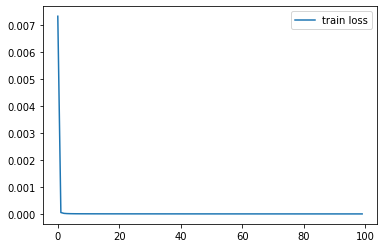

In [56]:
plt.plot(train_losses, label="train loss") 
plt.legend() 

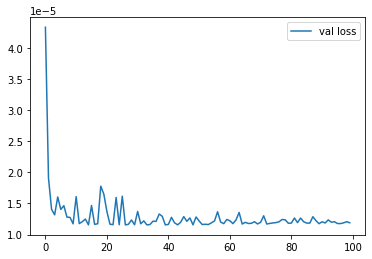

In [57]:
plt.plot(val_losses, label="val loss") 
plt.legend() 

In [64]:
# load test model 
test_model = TFN(n_var_past_cont = features,
                 n_var_future_cont = 0, 
                 n_var_past_disc = [60, 24, 32, 13], # minutes, hours, days, months
                 n_var_future_disc = [60, 24, 32, 13],
                 dim_model = 160)  

checkpoint = torch.load("TFT_feature_engineered_with_XRP.pt") 

test_model.load_state_dict(checkpoint)

test_model.eval() 

test_model.cuda() 

TFN(
  (vs_past): VSN(
    (fc): Linear(in_features=1, out_features=160, bias=False)
    (input_grn): GRN(
      (fc1): Linear(in_features=160, out_features=10, bias=True)
      (fc2): Linear(in_features=10, out_features=160, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (gate): GLU(
        (fc1): Linear(in_features=160, out_features=160, bias=True)
        (fc2): Linear(in_features=160, out_features=160, bias=True)
      )
      (norm): LayerNorm((160,), eps=1e-05, elementwise_affine=True)
    )
    (vs_grn): GRN(
      (skip): Linear(in_features=12640, out_features=79, bias=True)
      (fc1): Linear(in_features=12640, out_features=10, bias=True)
      (fc2): Linear(in_features=10, out_features=79, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (gate): GLU(
        (fc1): Linear(in_features=79, out_features=79, bias=True)
        (fc2): Linear(in_features=79, out_features=79, bias=True)
      )
      (norm): LayerNorm((79,), eps=1e-05, elementwise_a

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

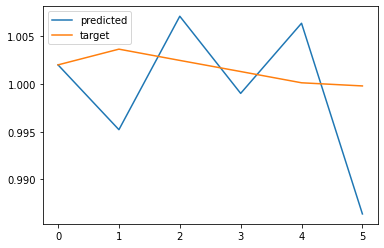

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

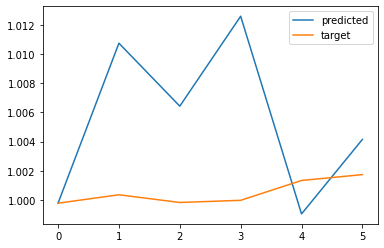

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

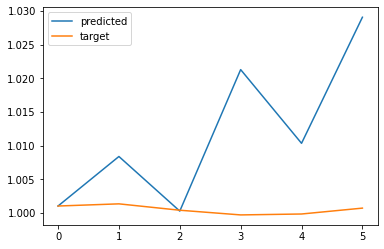

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

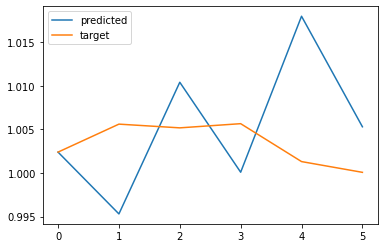

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

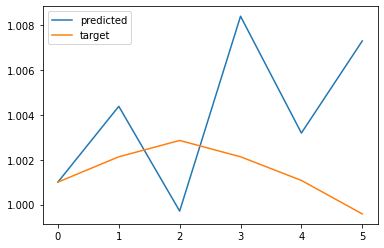

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

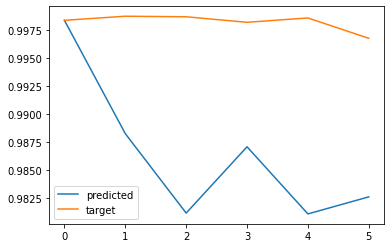

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

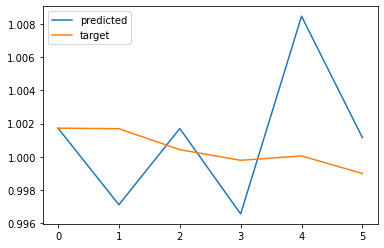

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

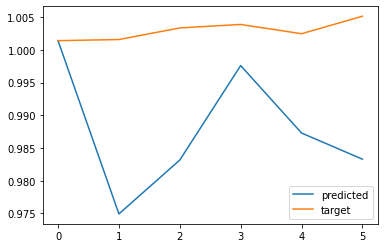

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

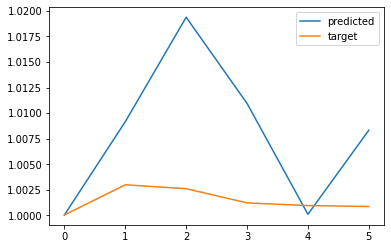

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

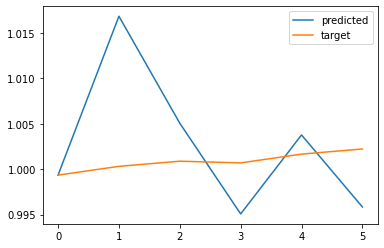

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

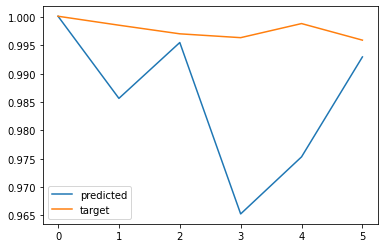

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

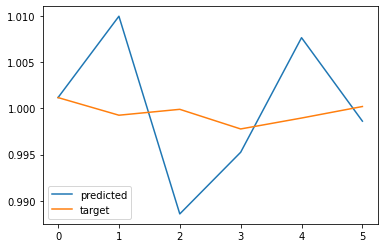

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

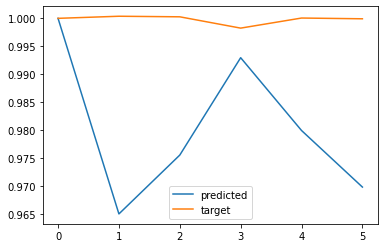

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

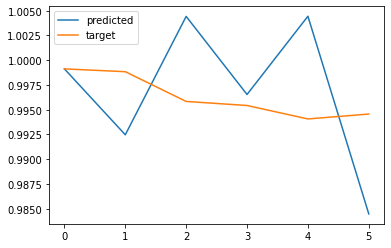

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

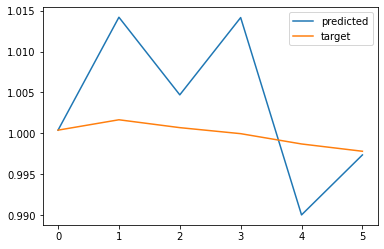

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

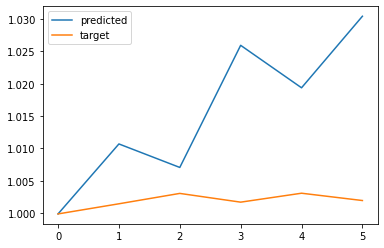

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

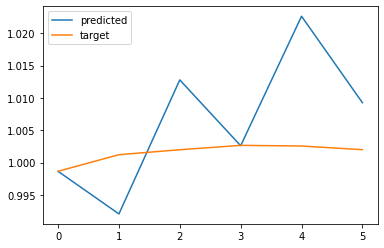

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

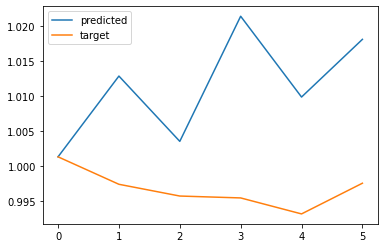

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

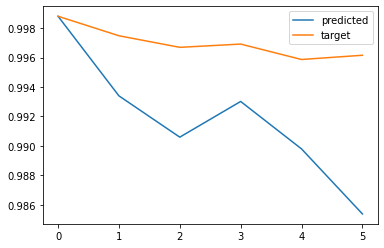

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

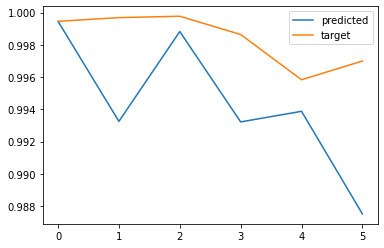

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

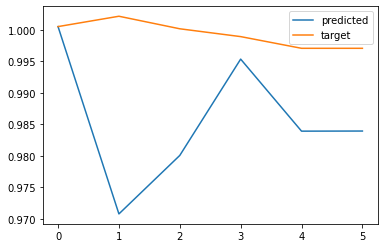

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

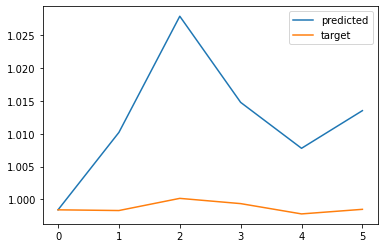

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

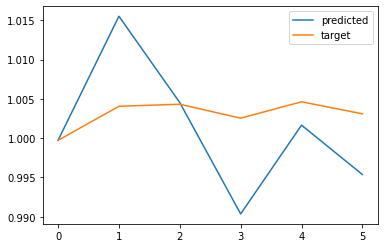

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

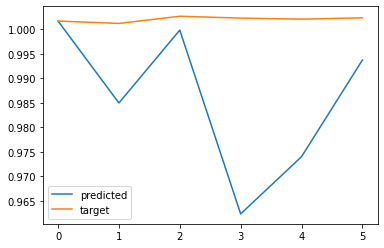

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

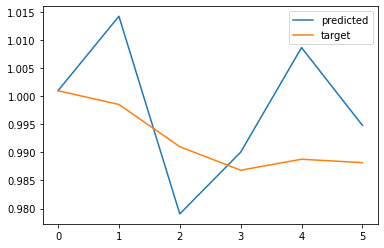

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

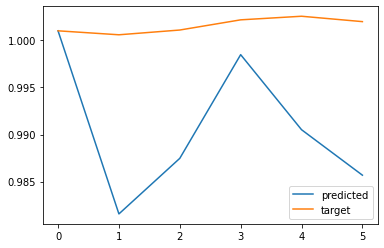

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

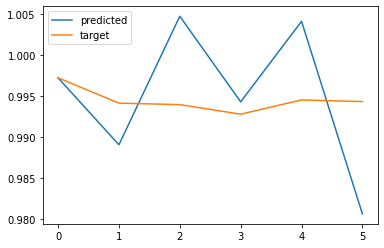

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

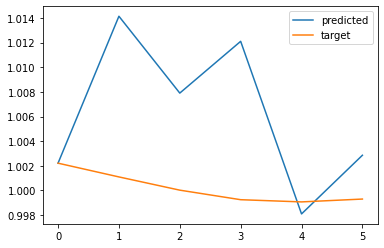

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

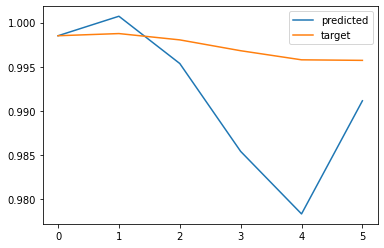

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

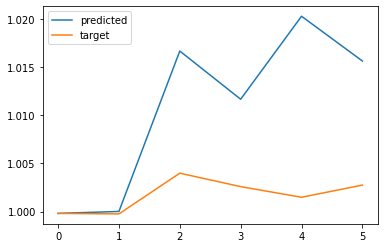

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

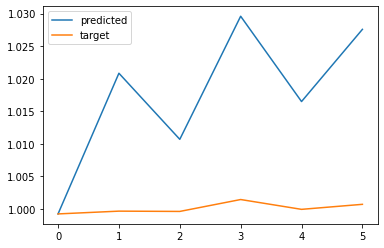

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

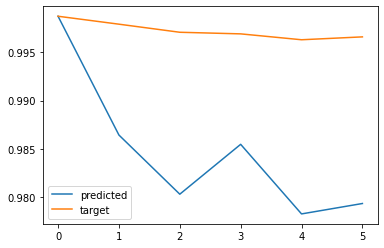

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

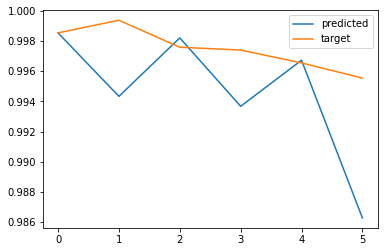

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

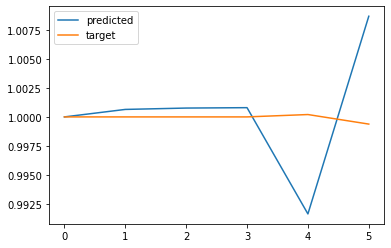

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

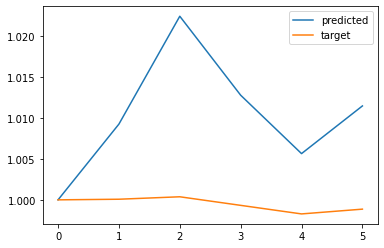

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

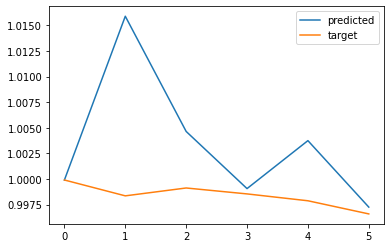

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

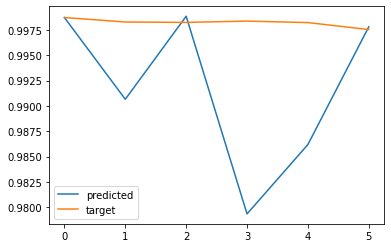

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

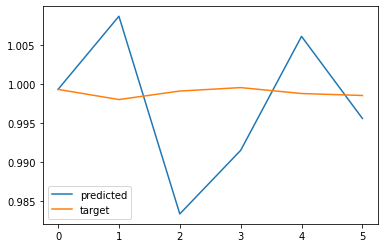

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

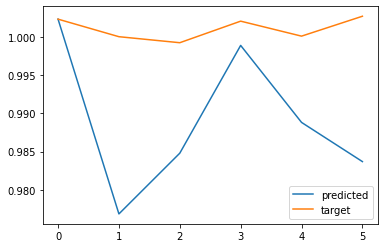

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

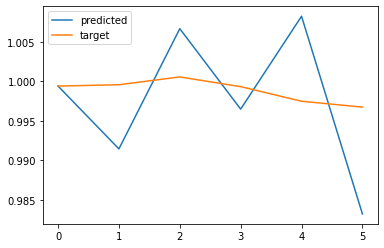

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

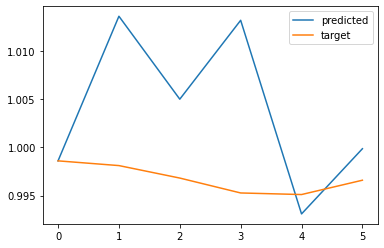

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

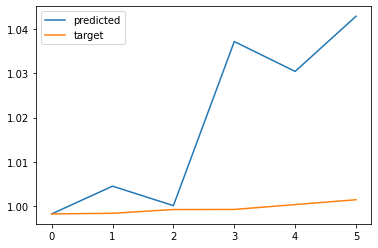

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

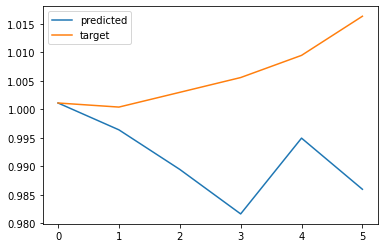

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

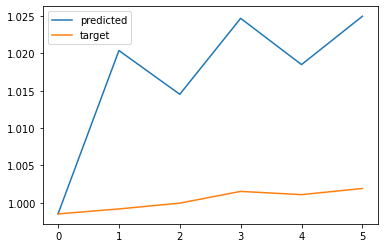

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

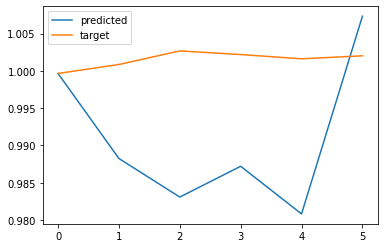

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

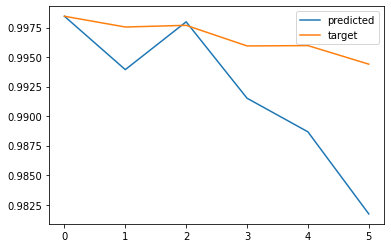

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

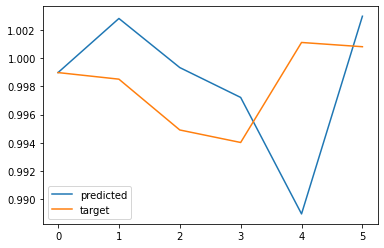

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

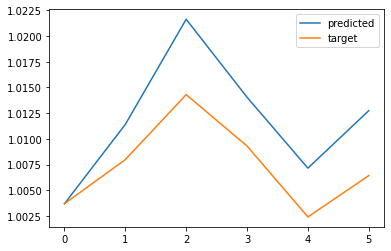

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

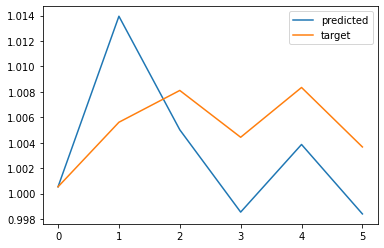

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

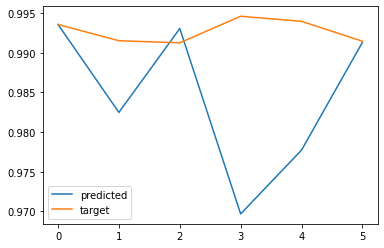

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

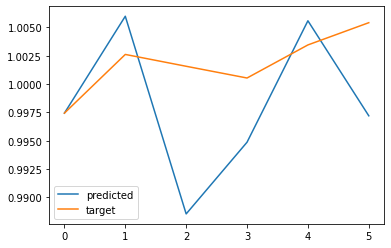

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

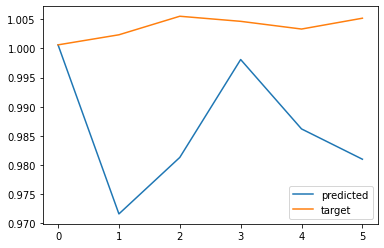

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

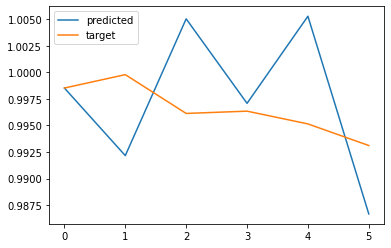

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

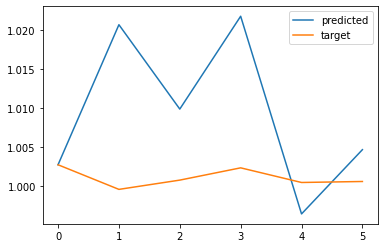

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

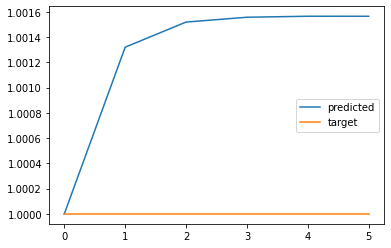

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

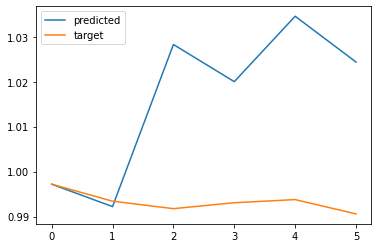

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

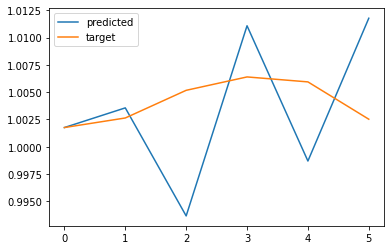

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

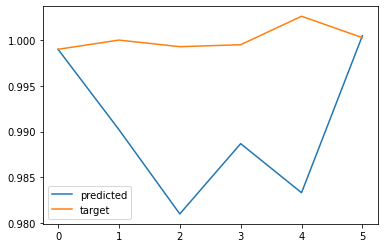

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

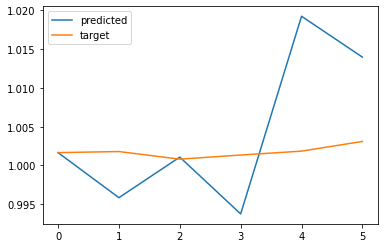

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

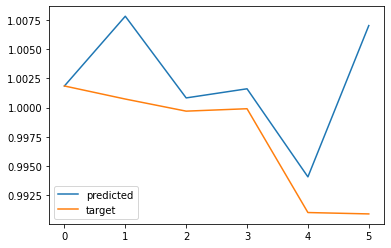

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

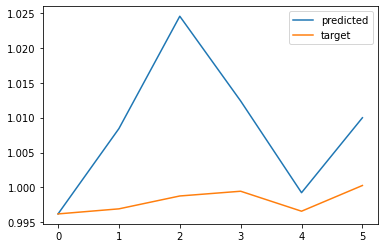

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

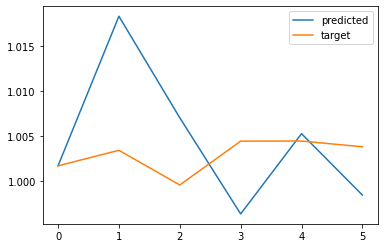

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

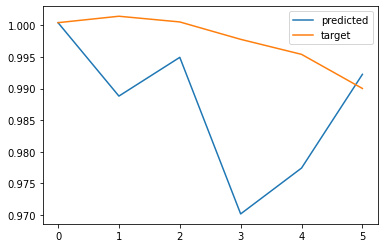

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

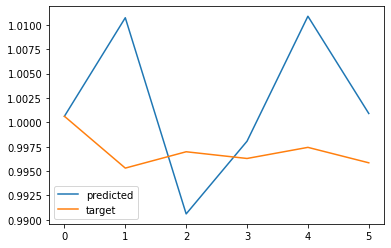

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

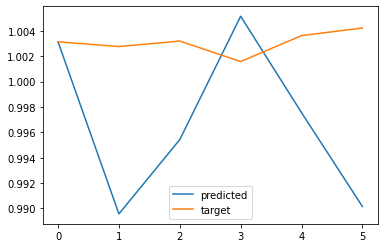

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

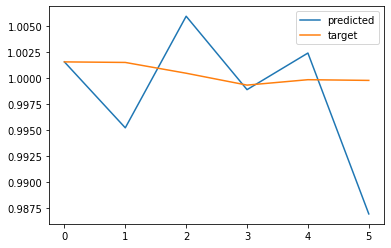

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

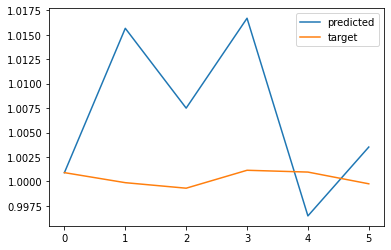

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

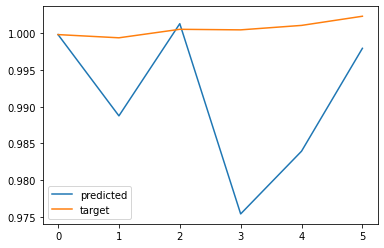

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

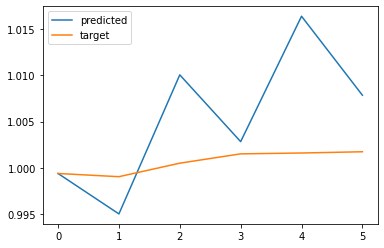

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

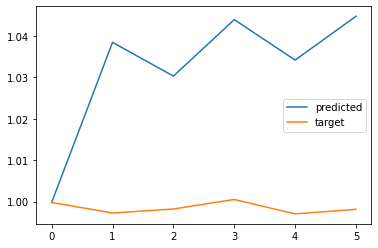

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

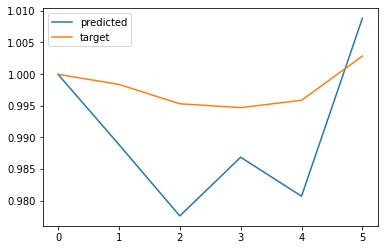

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

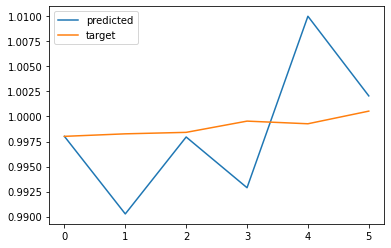

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

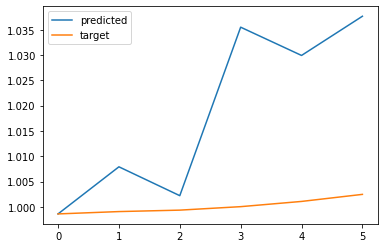

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

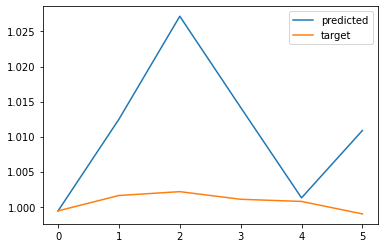

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

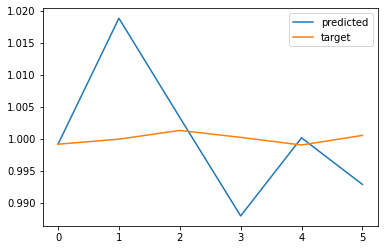

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

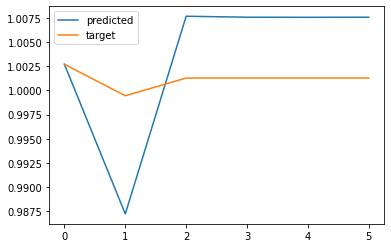

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

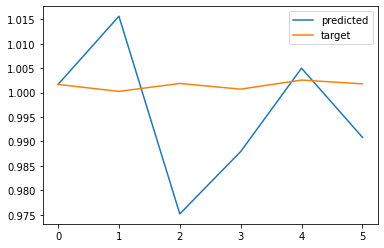

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

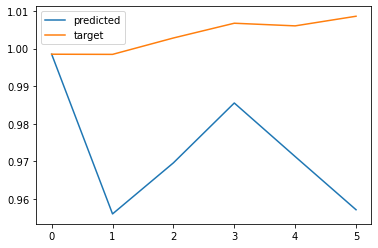

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

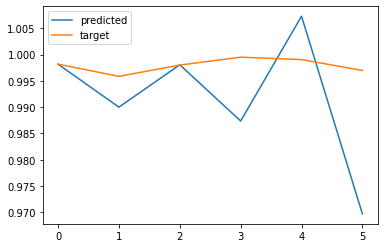

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

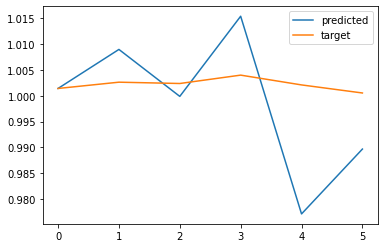

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

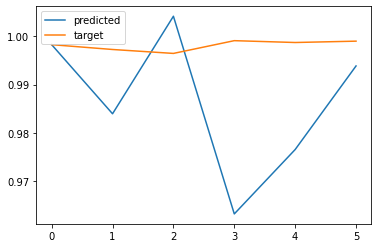

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

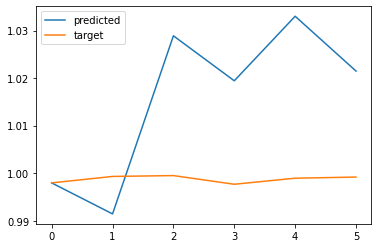

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

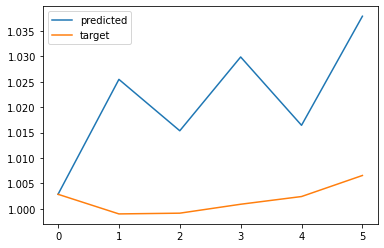

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

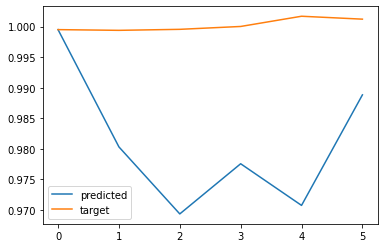

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

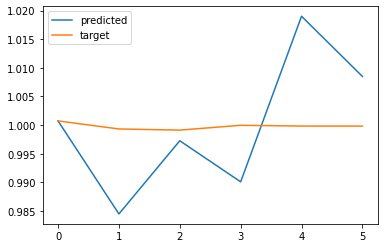

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

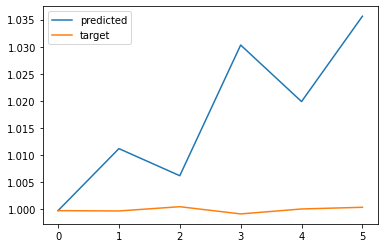

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

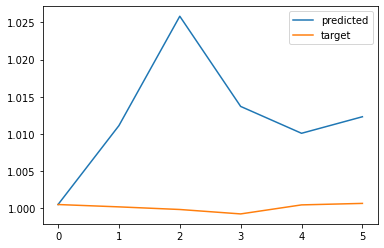

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

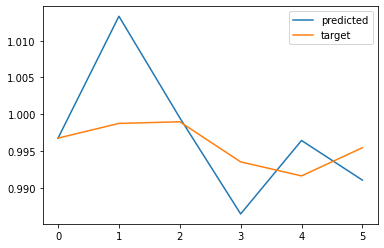

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

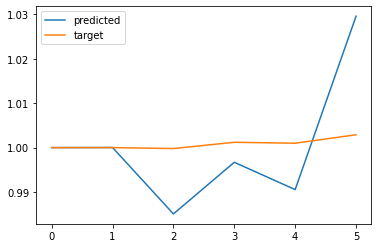

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

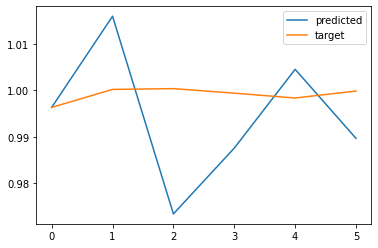

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

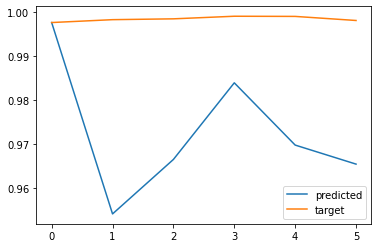

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

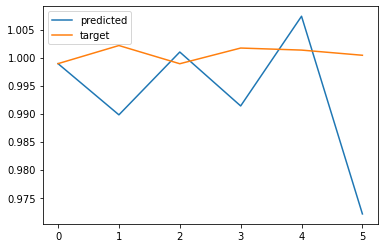

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

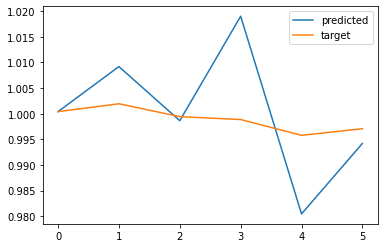

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

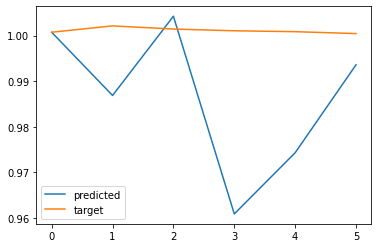

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

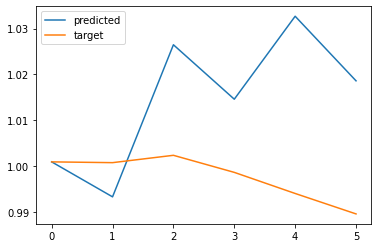

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

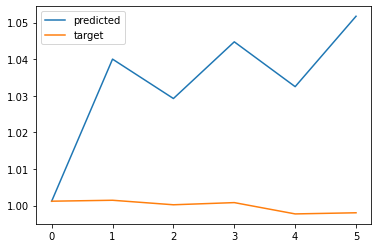

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

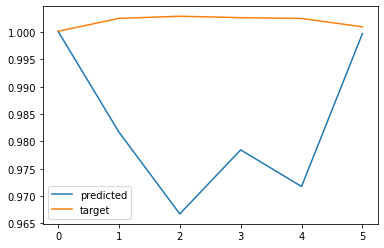

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

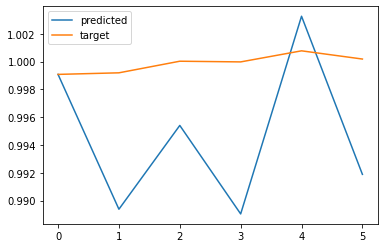

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

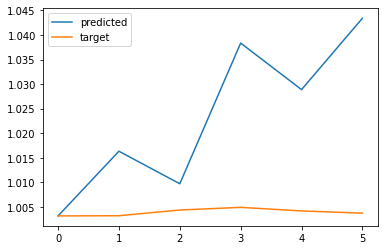

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

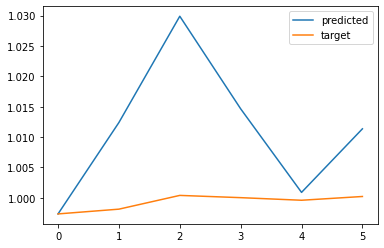

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

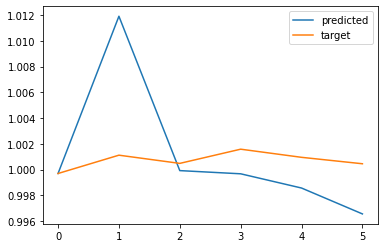

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

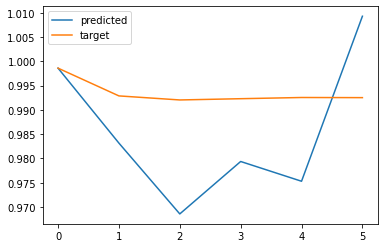

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

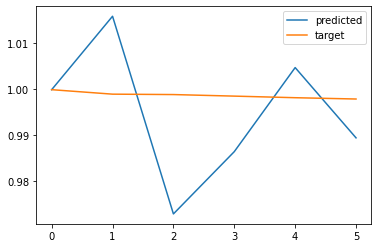

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

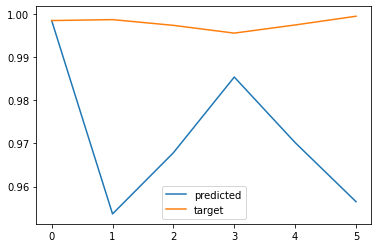

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

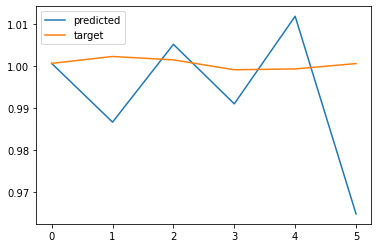

In [67]:
acc = 0 
total = 0 

all_cols = val_df.columns 

for batch in val_dataloader:
    past_cont = batch['past_cont'].to(device) 
    past_disc = batch['past_disc'].to(device) 
    target_seq = batch['target_seq'].to(device) 
    future_disc = batch['future_disc'].to(device)
        
    past_disc = one_hot(past_disc, [60, 24, 32, 13]) 
    future_disc = one_hot(future_disc, [60, 24, 32, 13]) 
        
    test_model.reset(batch_size=past_cont.shape[0], gpu=True) 
    with torch.no_grad():
        net_out, vs_weights = test_model(past_cont, past_disc, None, future_disc)  
    
    predicted = net_out[0,:,:].detach().cpu().numpy() 
    actual = target_seq[0,:,:].detach().cpu().numpy() 
    
    diff = actual[0] - predicted[0] 
    predicted += diff 
        
    # calculate accuracy 
    for i in range(past_cont.shape[0]): 
        pred_seq = net_out[i,:,:].detach().cpu().numpy() 
        actual_seq = target_seq[i,:,:].detach().cpu().numpy() 
        diff = actual_seq[0] - pred_seq[0] 
        pred_seq += diff  
        actual_diff = actual_seq[0] - actual_seq[5] 
        pred_diff = pred_seq[0] - pred_seq[5] 
        if (actual_diff >= 0 and pred_diff) >= 0 or (actual_diff < 0 and pred_diff < 0):  
            acc += 1   
        total += 1 
            
    plt.plot(predicted, label="predicted") 
    plt.plot(actual, label="target")
    plt.legend() 
    plt.show() 
                                    

In [68]:
print("Total Accuracy = {:.2f}%".format(acc / tot al * 100))

Total Accuracy = 79.55%
